<a href="https://colab.research.google.com/github/acmilannesta/Bert-embedding/blob/master/CDC/CDC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Link with github project folder

In [1]:
!git clone https://github.com/acmilannesta/Bert-embedding

Cloning into 'Bert-embedding'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 115 (delta 50), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (115/115), 11.49 MiB | 5.62 MiB/s, done.
Resolving deltas: 100% (50/50), done.


In [1]:
import json
import numpy as np
import pandas as pd
from random import choice
import re, os, gc
import codecs
from keras.layers import *
from keras.models import Model
import keras.backend as K
from keras.optimizers import Adam, SGD
from keras.callbacks import Callback, LearningRateScheduler
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


## Load Dataset
1. Add event weight
2. Reassign event code (0-47) for all
3. Remove age and strings related with age/sex


In [0]:
train = pd.read_csv('Bert-embedding/CDC/train.csv')
test = pd.read_csv('Bert-embedding/CDC/test.csv')
wt = pd.DataFrame(train.event.value_counts()/len(train)).rename(columns={'event':'weight'})
wt['event'] = wt.index
train = train.merge(wt, how='left', on='event')
train['event_idx'] = train.event.map({y:x for x, y in enumerate(np.sort(train.event.unique()))})

def df_str(data_df):
    a = data_df.apply(lambda x: x.text.replace(str(x.age), ''), axis=1).tolist()
    b = r'YOM|YOF|YM|YF|YO M|YO F|Y O M|Y O F|Y O MALE|Y O FEMALE|' \
        r'YO WHITE MALE|YO WHITE FEMALE|YOWF|YOWM|' \
        r'YO BLACK MALE|YO BLACK FEMALE|YOBF|YOBM'
    data_df['text'] = [re.sub(b, '', x) for x in a]
    return data_df

train = df_str(train)
test = df_str(test)

## EDA: Word frequencies by Event Type

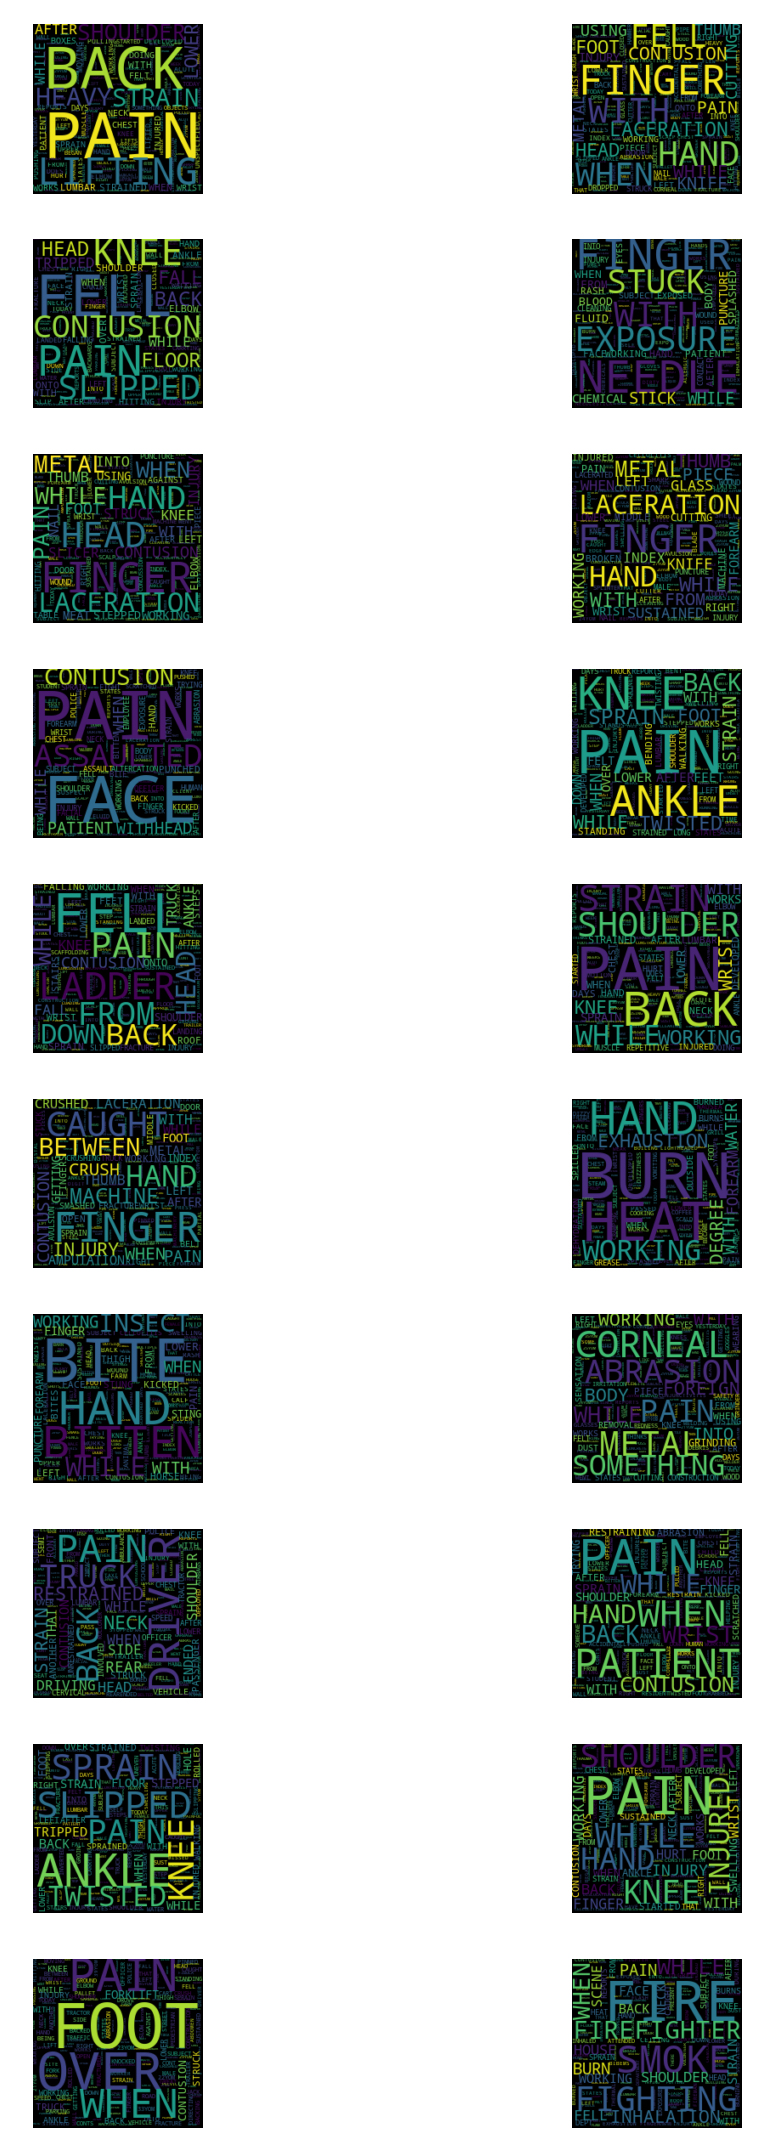

In [0]:
# Worclouds for top 20 events 
from itertools import groupby 
from wordcloud import WordCloud
import matplotlib.pyplot as plt
train['text_grouped'] = train.groupby('event')['text'].transform(lambda x: ' '.join(x))
x = train[['event', 'text_grouped', 'weight']].drop_duplicates('event').sort_values('weight', ascending=False)
x.reset_index(drop=True, inplace=True)

f, ax = plt.subplots(10, 2, figsize=(30,30))

for seq in range(20):
    string = x.loc[seq, 'text_grouped'].split(' ')
    counts = [(len(list(c)),i) for i,c in groupby(sorted(string)) if len(i)>3 and i!='WORK'] 
    counts_dict = {x[1]:x[0] for x in counts}

    wordcloud = WordCloud(height=200, width=200, margin=0, collocations=False).generate_from_frequencies(counts_dict)
    
    ax[seq//2, seq%2].imshow(wordcloud, interpolation='bilinear')
    ax[seq//2, seq%2].set_title('event:'+str(x.loc[seq, 'event']) #+' weight:'+str(round(x.loc[seq, 'weight'], 2)),
                    ,fontsize=16, color='white')
    ax[seq//2, seq%2].set_axis_off()
    ax[seq//2, seq%2].margins(x=0, y=0)
    plt.tight_layout(w_pad=0.025)


# BERT

In [3]:
!pip install keras_bert
from keras_bert import load_trained_model_from_checkpoint, Tokenizer, AdamWarmup, calc_train_steps

## Download BERT checkpoint and dictionary

In [0]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
# !wget https://storage.googleapis.com/bert_models/2019_05_30/wwm_uncased_L-24_H-1024_A-16.zip
!unzip uncased_L-12_H-768_A-12.zip
# !unzip wwm_uncased_L-24_H-1024_A-16.zip

## Parameter setting

In [0]:
MAXLEN = 142 #@param {type:'slider', min:50, max:300, step:1}
BATCH_SIZE = 16 #@param {type:'slider', min:8, max:32, step:8}
config_path = 'uncased_L-12_H-768_A-12/bert_config.json' #@param ['uncased_L-12_H-768_A-12/bert_config.json', 'wwm_uncased_L-24_H-1024_A-16/bert_config.json', 'drive/My Drive/biobert_pretrain_output_all_notes_150000/bert_config.json']
checkpoint_path = 'uncased_L-12_H-768_A-12/bert_model.ckpt' #@param ['uncased_L-12_H-768_A-12/bert_model.ckpt', 'wwm_uncased_L-24_H-1024_A-16/bert_model.ckpt', '/drive/My Drive/biobert_pretrain_output_all_notes_150000/model.ckpt']
dict_path = 'uncased_L-12_H-768_A-12/vocab.txt' #@param ['uncased_L-12_H-768_A-12/vocab.txt', 'wwm_uncased_L-24_H-1024_A-16/vocab.txt', 'drive/My Drive/biobert_pretrain_output_all_notes_150000/vocab.txt']

## Tokenize train and validation set

In [0]:
token_dict = {}
with codecs.open(dict_path, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        token_dict[token] = len(token_dict)
tokenizer = Tokenizer(token_dict)

In [6]:
def convert_data(data_df):
    # data_df.sample(frac=1, random_state=0)
    data_df.reset_index(drop=True, inplace=True)
    global tokenizer
    indices = []
    for i in tqdm(range(len(data_df))):
        ids, segments = tokenizer.encode(data_df.loc[i, 'text'])
        indices.append(ids)
    targets = data_df['event_idx']
    weights = data_df['weight']
    aux = data_df[['age', 'sex']].apply(lambda x: (x - min(x)) / (max(x)-min(x)))
    return indices, np.array(targets), np.array(weights), np.array(aux)

tr, val = train_test_split(train, test_size=0.2, random_state=0)
tr_x, tr_y, tr_wt, tr_aux = convert_data(tr)
val_x, val_y, val_wt, val_aux = convert_data(val)

100%|██████████| 30792/30792 [00:06<00:00, 4503.94it/s]


## Data Generator

In [0]:
def seq_padding(X, padding=0):
    L = [len(x) for x in X]
    ML = max(L)
    return np.array([np.concatenate([x, [padding] * (ML - len(x))]) if len(x) < ML else x for x in X])

class data_generator:
    def __init__(self, data, batch_size=BATCH_SIZE, maxlen=MAXLEN, branch='train'):
        self.data = data
        self.batch_size = batch_size
        self.maxlen = maxlen
        self.branch = branch
        self.steps = len(self.data) // self.batch_size
        if len(self.data) % self.batch_size != 0:
            self.steps += 1

    def __len__(self):
        return self.steps

    def __iter__(self):
        while True:
            if self.branch == 'train':
                np.random.shuffle(self.data)
            for i in range(self.steps):
                d = self.data[i * self.batch_size: (i + 1) * self.batch_size]
                X1 = seq_padding([x[0] for x in d])
                Y = np.array([x[1] for x in d])
                W = np.array([x[2] for x in d])
                aux = np.array([x[3] for x in d])
                X2 = np.zeros_like(X1)
                yield [X1, X2, W, aux], Y

##Model Assemble

In [8]:
bert_model = load_trained_model_from_checkpoint(
    config_path,
    checkpoint_path,
    seq_len = MAXLEN,
    trainable=True)

x1_in = Input(shape=(None,))
x2_in = Input(shape=(None,))
w_in = Input(shape=(1,))
aux_in = Input(shape=(2, ))
inputs = bert_model([x1_in, x2_in])

dense = Lambda(lambda x: x[:, 0])(inputs)
dense = concatenate([dense, aux_in])
outputs = Dense(48, activation='softmax')(dense)
model = Model([x1_in, x2_in, w_in, aux_in], outputs)

decay_steps, warmup_steps = calc_train_steps(
    len(tr_x),
    batch_size=BATCH_SIZE,
    epochs=2,
)

model.compile(
    loss='sparse_categorical_crossentropy',
    # optimizer=Adam(1e-5),
    optimizer=AdamWarmup(decay_steps=decay_steps, warmup_steps=warmup_steps, lr=1e-4, min_lr=1e-6),
    metrics= ['sparse_categorical_accuracy']
)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.











In [21]:
del model
gc.collect()

436

## Batchwise evaluation callback

In [0]:
class IntervalEvaluation(Callback):
    def __init__(self, validation_data, label, weight, interval=3000):
        # super(Callback, self).__init__()
        self.seen = 0
        self.interval = interval
        self.validation_data = validation_data
        self.label = label
        self.weight = weight
    def on_batch_end(self, batch, logs={}):
        self.seen += logs.get('num_steps', 1)
        if self.seen % self.interval == 0:
            y_pred = self.model.predict_generator(self.validation_data.__iter__(), len(self.validation_data))
            score = f1_score(self.label, np.argmax(y_pred, 1), average='weighted', sample_weight=self.weight)
            print(" - interval evaluation - batch: {:d} - score: {:.4f}".format(self.seen, score))

In [0]:
train_D = data_generator(list(zip(tr_x, tr_y, tr_wt, tr_aux)))
valid_D = data_generator(list(zip(val_x, val_y, val_wt, val_aux)), branch='valid')
ival = IntervalEvaluation(validation_data=valid_D, label=val_y, weight=val_wt, interval = len(train_D))
model.fit_generator(    
    train_D.__iter__(),
    steps_per_epoch=len(train_D),
    epochs=2,
    # validation_data=valid_D.__iter__(),
    # validation_steps=len(valid_D),
    callbacks = [ival]
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/2
5512/7698 [====================>.........] - ETA: 13:20 - loss: 0.6779 - sparse_categorical_accuracy: 0.7996

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
model.save('drive/My Drive/CDC Model/Bert_base_aux_0.9188.h5')

## Prediction on test set

In [15]:
test_indices = []
for i in tqdm(range(len(test))):
    ids, segments = tokenizer.encode(test.loc[i, 'text'])
    test_indices.append(ids)
test_aux = np.array(test[['age', 'sex']].apply(lambda x: (x - min(x)) / (max(x)-min(x))))

class test_generator:
    def __init__(self, data, batch_size=BATCH_SIZE, maxlen=MAXLEN):
        self.data = data
        self.batch_size = batch_size
        self.maxlen = maxlen
        self.steps = len(self.data) // self.batch_size
        if len(self.data) % self.batch_size != 0:
            self.steps += 1

    def __len__(self):
        return self.steps

    def __iter__(self):
        while True:
            for i in range(self.steps):
                d = self.data[i * self.batch_size: (i + 1) * self.batch_size]
                X1 = seq_padding([x[0] for x in d])
                X2 = np.zeros_like(X1)
                W = np.ones(len(X1))
                aux = np.array([x[1] for x in d])
                yield [X1, X2, W, aux]

100%|██████████| 75864/75864 [00:17<00:00, 4244.79it/s]


In [16]:
test_D = test_generator(list(zip(test_indices, test_aux)))
pred = model.predict_generator(test_D.__iter__(), len(test_D), verbose=1)
test['event'] = np.argmax(pred, 1)
test['event'] = test.event.map({x:y for x, y in enumerate(np.sort(train.event.unique()))})

4742/4742 [==============================] - 366s 77ms/step


In [0]:
test.to_csv('solution.csv', index=False)

# xlnet

In [0]:
!wget https://storage.googleapis.com/xlnet/released_models/cased_L-12_H-768_A-12.zip
!unzip cased_L-12_H-768_A-12.zip

--2019-10-20 20:54:01--  https://storage.googleapis.com/xlnet/released_models/cased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 2404:6800:4008:c01::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 433638019 (414M) [application/zip]
Saving to: ‘cased_L-12_H-768_A-12.zip’

cased_L-12_H-768_A- 100%[===================>] 413.55M  60.4MB/s    in 6.1s    

2019-10-20 20:54:07 (67.6 MB/s) - ‘cased_L-12_H-768_A-12.zip’ saved [433638019/433638019]

Archive:  cased_L-12_H-768_A-12.zip
   creating: xlnet_cased_L-12_H-768_A-12/
  inflating: xlnet_cased_L-12_H-768_A-12/xlnet_model.ckpt.index  
  inflating: xlnet_cased_L-12_H-768_A-12/xlnet_model.ckpt.data-00000-of-00001  
  inflating: xlnet_cased_L-12_H-768_A-12/spiece.model  
  inflating: xlnet_cased_L-12_H-768_A-12/xlnet_model.ckpt.meta  
  inflating: xlnet_cased_L-12_H-768_A-12/xlnet_conf

In [0]:
!pip install keras_xlnet

     |████████████████████████████████| 317kB 4.3MB/s 
     |████████████████████████████████| 1.0MB 46.5MB/s 
  Created wheel for keras-xlnet: filename=keras_xlnet-0.17.0-cp36-none-any.whl size=44415 sha256=169dff2ea8c66129bbf9d63fa755003abd04a62de7007208684aab1f78a78513
  Stored in directory: /root/.cache/pip/wheels/7e/0b/a5/7adacda75d0c5117dfb3e986ba3f47b7fadea7e7e0a6f1b0c9
  Created wheel for keras-transformer-xl: filename=keras_transformer_xl-0.11.0-cp36-none-any.whl size=20658 sha256=4100f33bd3ad0d86ff7bdf0321ad253266152481457cee393fdac50c30205144
  Stored in directory: /root/.cache/pip/wheels/ad/8d/1d/d93406806db7a917d1d59054477c1473db1e16fbd789f6dbc6
  Created wheel for keras-trans-mask: filename=keras_trans_mask-0.3.0-cp36-none-any.whl size=4206 sha256=59ccf76b22926ec95094f9f8b6b937457e68d4ac4c59ef67271ef4a62bb3d3c1
  Stored in directory: /root/.cache/pip/wheels/a4/a5/2a/88a6f3c9276c7d55e1322d7aa46924172de2d68db442fc2727
  Created wheel for keras-adaptive-softmax: filename=ker

## Parameter Setting

In [0]:
import os
from keras_xlnet import Tokenizer, load_trained_model_from_checkpoint, ATTENTION_TYPE_BI, ATTENTION_TYPE_UNI

checkpoint_path = 'xlnet_cased_L-12_H-768_A-12'
MEMLEN=512
BATCH_SIZE=8

## Tokenize train and validation set

In [0]:
tokenizer = Tokenizer(os.path.join(checkpoint_path, 'spiece.model'))
def convert_data(data_df):
    data_df.reset_index(drop=True, inplace=True)
    global tokenizer
    indices, targets, weights = [], [], []
    for i in tqdm(range(len(data_df))):
        ids = tokenizer.encode(data_df.loc[i, 'text'])
        ids.extend([tokenizer.SYM_SEP, tokenizer.SYM_CLS])
        indices.append(ids)
        targets.append(data_df.loc[i, 'event_idx'])
        weights.append(data_df.loc[i, 'weight'])
    items = list(zip(indices, targets, weights))
    np.random.shuffle(items)
    indices, targets, weights = zip(*items)
    return indices, np.array(targets), np.array(weights)

tr, val = train_test_split(train, test_size=0.2, random_state=0)
tr_x, tr_y, tr_wt = convert_data(tr)
val_x, val_y, val_wt = convert_data(val)

100%|██████████| 30792/30792 [00:03<00:00, 7894.43it/s]


## Data generator

In [0]:
def seq_padding(X, padding=0):
  L = [len(x) for x in X]
  ML = max(L)
  return np.array([np.concatenate([x, [padding] * (ML - len(x))]) if len(x) < ML else x for x in X])

def seq_seg(X):
  seg = [[tokenizer.SYM_UNK]*(len(x)-1)+[tokenizer.SYM_EOS] for x in X]
  ML = max([len(x) for x in X])    
  return np.array([np.concatenate([x, [tokenizer.SYM_SEP] * (ML - len(x))]) if len(x) < ML else x for x in seg])

def seq_mask(X):
  mask = [[tokenizer.SYM_UNK]*len(x) for x in X]
  ML = max([len(x) for x in X])    
  return np.array([np.concatenate([x, [tokenizer.SYM_BOS] * (ML - len(x))]) if len(x) < ML else x for x in mask])


class data_generator:
  def __init__(self, data, batch_size=BATCH_SIZE, memlen=MEMLEN):
    self.data = data
    self.batch_size = batch_size
    self.memlen = memlen
    self.steps = len(self.data) // self.batch_size
    if len(self.data) % self.batch_size != 0:
        self.steps += 1
  def __len__(self):
    return self.steps
  def __iter__(self):
    while True:
        for i in range(self.steps):
            d = self.data[i * self.batch_size: (i + 1) * self.batch_size]
            X1 = seq_padding([x[0] for x in d])
            # segments
            X2 = seq_seg(([x[0] for x in d]))
            # memories
            X3 = np.array([self.memlen for i in range(len(d))])
            # masks
            X4 = seq_mask(([x[0] for x in d]))
            Y = np.array([x[1] for x in d])
            yield [X1, X2, X3, X4], Y

## Model Assemble

In [0]:
xlnet_model = load_trained_model_from_checkpoint(
    config_path=os.path.join(checkpoint_path, 'xlnet_config.json'),
    checkpoint_path=os.path.join(checkpoint_path, 'xlnet_model.ckpt'),
    batch_size=BATCH_SIZE, #16
    memory_len=MEMLEN, #512
    target_len=142, #128
    in_train_phase=True,
    # attention_type=ATTENTION_TYPE_BI,
)

In [0]:
x1_in = Input(shape=(None,))
x2_in = Input(shape=(None,))
x3_in = Input(shape=(1,))
x4_in = Input(shape=(None,))

x = xlnet_model([x1_in, x2_in, x3_in, x4_in])
x = Lambda(lambda x: x[:, 0])(x)
p = Dense(48, activation='softmax')(x)

model = Model([x1_in, x2_in, x3_in, x4_in], p)

decay_steps, warmup_steps = calc_train_steps(
    len(tr_x),
    batch_size=BATCH_SIZE,
    epochs=1
)

model.compile(
    loss='sparse_categorical_crossentropy',
    # optimizer=Adam(1e-4),
    optimizer=AdamWarmup(decay_steps=decay_steps, warmup_steps=warmup_steps, learning_rate=1e-4, min_lr=1e-5),
    metrics= ['sparse_categorical_accuracy']
)

## Batchwise evaluation callback

In [0]:
class IntervalEvaluation(Callback):
    def __init__(self, validation_data, label, weight, interval=3000):
        # super(Callback, self).__init__()
        self.seen = 0
        self.interval = interval
        self.validation_data = validation_data
        self.label = label
        self.weight = weight
    def on_batch_end(self, batch, logs={}):
        self.seen += logs.get('num_steps', 1)
        if self.seen % self.interval == 0:
            y_pred = self.model.predict_generator(self.validation_data.__iter__(), len(self.validation_data))
            score = f1_score(self.label, np.argmax(y_pred, 1), average='weighted', sample_weight=self.weight)
            print(" - interval evaluation - batch: {:d} - score: {:.4f}".format(self.seen, score))

In [0]:
train_D = data_generator(list(zip(tr_x, tr_y)))
valid_D = data_generator(list(zip(val_x, val_y)))
ival = IntervalEvaluation(validation_data=valid_D, label=val_y, weight=val_wt, interval = len(train_D))
model.fit_generator(
    train_D.__iter__(),
    steps_per_epoch=len(train_D),
    epochs=1,
    # validation_data=valid_D.__iter__(),
    # validation_steps=len(valid_D),
    callbacks = [ival]
)

In [0]:
del model
gc.collect()

In [0]:
model.save('drive/My Drive/xlnet_base.h5')

## Prediction on test set

In [0]:
test_indices = []
for i in tqdm(range(len(test))):
    ids = tokenizer.encode(test.loc[i, 'text'])
    ids.extend([tokenizer.SYM_SEP, tokenizer.SYM_CLS])
    test_indices.append(ids)

class test_generator:
  def __init__(self, data, batch_size=BATCH_SIZE, memlen=MEMLEN):
    self.data = data
    self.batch_size = batch_size
    self.memlen = memlen
    self.steps = len(self.data) // self.batch_size
    if len(self.data) % self.batch_size != 0:
        self.steps += 1
  def __len__(self):
    return self.steps
  def __iter__(self):
    while True:
        for i in range(self.steps):
            d = self.data[i * self.batch_size: (i + 1) * self.batch_size]
            X1 = seq_padding(d)
            # segments
            X2 = seq_seg(d)
            # memories
            X3 = np.array([self.memlen for i in range(len(d))])
            # masks
            # X4 = seq_mask(([x[0] for x in d]))
            # Y = np.array([x[1] for x in d])
            yield [X1, X2, X3]

In [0]:
test_D = test_generator(test_indices)
pred = model.predict_generator(test_D.__iter__(), len(test_D), verbose=1)
test['event'] = np.argmax(pred, 1)
test['event'] = test.event.map({x:y for x, y in enumerate(np.sort(train.event.unique()))})

In [0]:
test.to_csv('solution.csv', index=False)